In [484]:
import random
from enum import Enum
from typing import Callable
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


In [485]:
# GLOBALS
OPS = 10  # Number of operations per input
ITERS = 10000 # Number of iterations to run
NUM_MUTATIONS = 5  # Number of mutations to add when new coverage is found
SUDDEN_DRIFT_WINDOW = 100  # Window size for sudden drift detection
GRADUAL_DRIFT_WINDOW = 1000  # Window size for gradual drift detection
DRIFT_THRESHOLD = 0.05  # P-value threshold for drift detection
SATURATION_THRESHOLD = 0.5  # Growth rate ratio threshold for saturation (50% slowdown)
BREAKTHROUGH_THRESHOLD = 1.5  # Growth rate ratio threshold for breakthrough (150% speedup)
RANDOM_SEED = 42  # Random seed for reproducibility


In [486]:
class Operation(Enum):
    ADD = 0
    SUB = 1
    DIV = 2
    MUL = 3

class Calculator:
    """Simple integer-only calculator starting at 0.

    Operations:
      - add1(): add 1
      - sub1(): subtract 1
      - mul2(): multiply by 2
      - div2(): divide by 2 (rounds down for odd values)
      - reset(): reset value to 0 and clear log

    The calculator maintains a log of all values (starting with 0).
    Access the log via the .log attribute.
    """

    def __init__(self) -> None:
        self._value: int = 0
        self.log: list[int] = [0]

    def add1(self) -> None:
        self._value += 1
        self.log.append(self._value)

    def sub1(self) -> None:
        self._value -= 1
        self.log.append(self._value)

    def mul2(self) -> None:
        self._value *= 2
        self.log.append(self._value)

    def div2(self) -> None:
        self._value //= 2
        self.log.append(self._value)

    def reset(self) -> None:
        self._value = 0
        self.log = [0]

    def get(self) -> int:
        return self._value

    def parse(self, operations: list[Operation]) -> Callable[[], None]:
        """Parse a list of operations and return a nested function to execute them."""
        def execute() -> None:
            for op in operations:
                if op == Operation.ADD:
                    self.add1()
                elif op == Operation.SUB:
                    self.sub1()
                elif op == Operation.DIV:
                    self.div2()
                elif op == Operation.MUL:
                    self.mul2()
        return execute

    def calculate(self, operations: list[Operation]) -> list[int]:
        """Execute operations, copy log, reset, and return the copied log."""
        execute = self.parse(operations)
        execute()
        log_copy = self.log.copy()
        self.reset()
        return log_copy

    def __int__(self) -> int:
        return self._value

    def __repr__(self) -> str:
        return f"Calculator({self._value})"


In [487]:
def generate_random_operations(n: int = OPS) -> list[Operation]:
    """Generate a random list of operations of length n."""
    return [random.choice(list(Operation)) for _ in range(n)]

In [488]:
# Run calculator 1000 times with random operations and collect unique values
random.seed(RANDOM_SEED)
unique_values = set()
calc = Calculator()
random_coverage = []

for _ in range(ITERS):
    ops = generate_random_operations()
    log = calc.calculate(ops)
    unique_values.update(log)
    random_coverage.append(len(unique_values))

print(f"Total unique values generated: {len(unique_values)}")
print(f"Coverage over time: {random_coverage[:20]}...")  # Show first 20 steps
print(f"Final coverage: {random_coverage[-1]}")


Total unique values generated: 142
Coverage over time: [5, 5, 5, 8, 8, 8, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16]...
Final coverage: 142


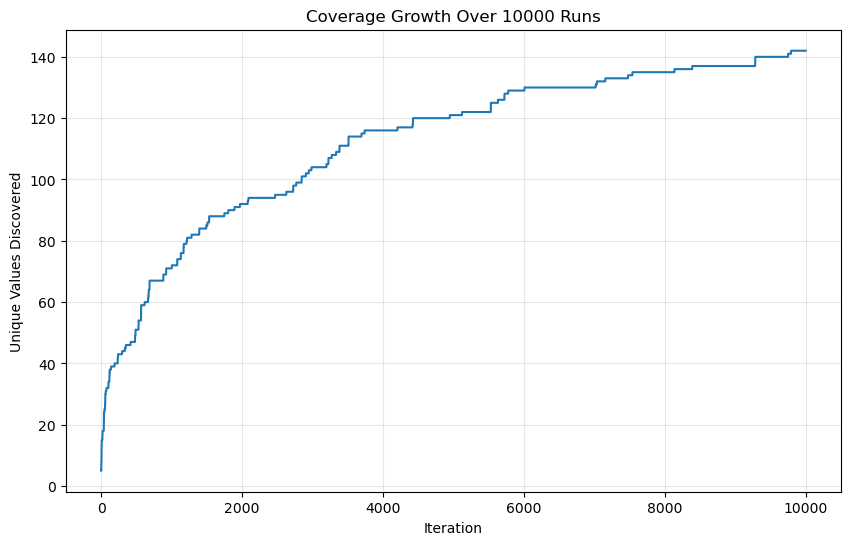

In [489]:
# Plot coverage over time
plt.figure(figsize=(10, 6))
plt.plot(random_coverage)
plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Coverage Growth Over {ITERS} Runs')
plt.grid(True, alpha=0.3)
plt.show()


In [490]:
class CoverageGuidedFuzzer:
    """Coverage-guided fuzzer that prioritizes operation sequences discovering new values."""
    
    def __init__(self, num_mutations: int = NUM_MUTATIONS):
        self.num_mutations = num_mutations
        self.unique_values: set[int] = set()
        self.coverage: list[int] = []
        self.corpus: list[list[Operation]] = []
        self.calc = Calculator()
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """
        Run the fuzzer for the specified number of iterations.
        Uses queue-based selection like AFL++.
        
        Returns:
            tuple of (unique_values, coverage_over_time)
        """
        for i in range(iters):
            # Queue-based selection: pick next item from queue, or generate random if empty
            if self.corpus:
                # Pick the next item from the queue (round-robin)
                ops = self.corpus.pop(0)
            else:
                # Generate completely random operations (initial seed)
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # If this sequence found new values, add multiple mutations to corpus
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage
    
    def mutate_operations(self, ops: list[Operation]) -> list[Operation]:
        """Mutate an operation sequence by changing or swapping operations (constant length)."""
        ops = ops.copy()
        mutation_type = random.choice(['change', 'swap'])
        
        if mutation_type == 'change' and len(ops) > 0:
            # Change a random operation
            idx = random.randint(0, len(ops) - 1)
            ops[idx] = random.choice(list(Operation))
        
        elif mutation_type == 'swap' and len(ops) > 1:
            # Swap two random operations
            idx1 = random.randint(0, len(ops) - 1)
            idx2 = random.randint(0, len(ops) - 1)
            ops[idx1], ops[idx2] = ops[idx2], ops[idx1]
        
        return ops


In [491]:
# Run coverage-guided fuzzer
print("Running coverage-guided fuzzer...")
random.seed(RANDOM_SEED)
fuzzer = CoverageGuidedFuzzer()
cg_unique_values, cg_coverage = fuzzer.fuzz(ITERS)

print(f"\nCoverage-Guided Fuzzer Results:")
print(f"Total unique values: {len(cg_unique_values)}")
print(f"Final coverage: {cg_coverage[-1]}")
print(f"Corpus size: {len(fuzzer.corpus)}")


Running coverage-guided fuzzer...

Coverage-Guided Fuzzer Results:
Total unique values: 189
Final coverage: 189
Corpus size: 0


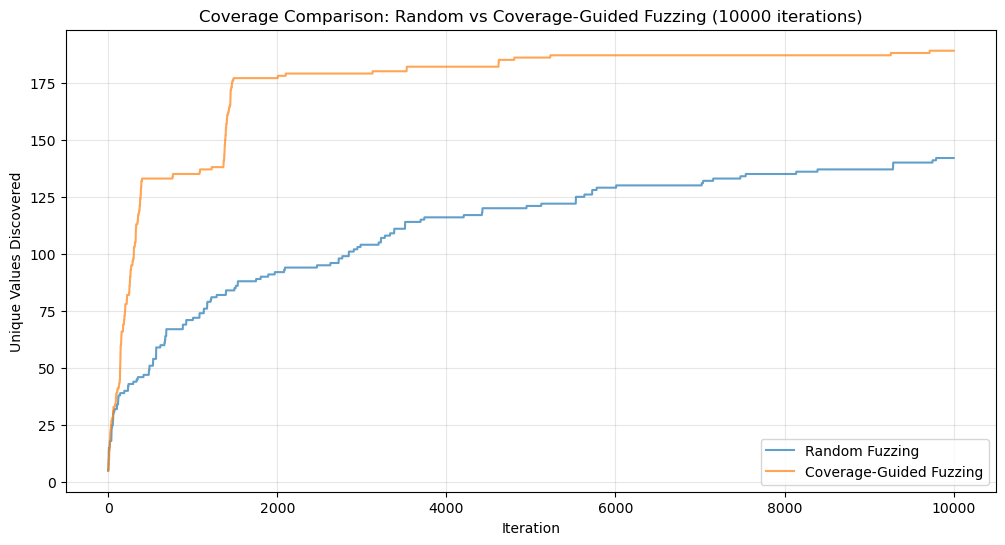


Final Coverage Comparison:
Random Fuzzing: 142 unique values
Coverage-Guided Fuzzing: 189 unique values
Improvement: 47 (33.10%)


In [492]:
# Compare coverage-guided vs random fuzzing
plt.figure(figsize=(12, 6))
plt.plot(random_coverage, label='Random Fuzzing', alpha=0.7)
plt.plot(cg_coverage, label='Coverage-Guided Fuzzing', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Coverage Comparison: Random vs Coverage-Guided Fuzzing ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Coverage Comparison:")
print(f"Random Fuzzing: {random_coverage[-1]} unique values")
print(f"Coverage-Guided Fuzzing: {cg_coverage[-1]} unique values")
print(f"Improvement: {cg_coverage[-1] - random_coverage[-1]} ({((cg_coverage[-1] - random_coverage[-1]) / random_coverage[-1] * 100):.2f}%)")


In [493]:
class ConceptDriftFuzzer:
    """Coverage-guided fuzzer with KS drift detection."""
    
    def __init__(self, num_mutations: int = NUM_MUTATIONS, 
                 sudden_drift_window: int = SUDDEN_DRIFT_WINDOW,
                 gradual_drift_window: int = GRADUAL_DRIFT_WINDOW,
                 drift_threshold: float = DRIFT_THRESHOLD,
                 reset_on_drift: bool = False):
        self.num_mutations = num_mutations
        self.sudden_drift_window = sudden_drift_window
        self.gradual_drift_window = gradual_drift_window
        self.drift_threshold = drift_threshold
        self.reset_on_drift = reset_on_drift
        
        self.unique_values: set[int] = set()
        self.coverage: list[int] = []
        self.corpus: list[list[Operation]] = []
        self.calc = Calculator()
        
        # Drift detection tracking
        self.values_window: list[list[int]] = []  # Store logs for each iteration
        self.sudden_drift_detected_at: list[int] = []  # Iterations where sudden drift was detected
        self.gradual_drift_detected_at: list[int] = []  # Iterations where gradual drift was detected
        self.ks_statistics: list[float] = []  # KS statistic at each check
        self.corpus_reset_at: list[int] = []  # Iterations where corpus was reset
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """
        Run the fuzzer for the specified number of iterations.
        Monitors for concept drift using KS test.
        
        Returns:
            tuple of (unique_values, coverage_over_time)
        """
        for i in range(iters):
            # Queue-based selection: pick next item from queue, or generate random if empty
            if self.corpus:
                ops = self.corpus.pop(0)
            else:
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # Store values for drift detection
            self.values_window.append(log)
            
            # Check for sudden drift every sudden_drift_window iterations
            if i > 0 and i % self.sudden_drift_window == 0 and len(self.values_window) >= 2 * self.sudden_drift_window:
                self._check_drift(i, drift_type='sudden')
            
            # Check for gradual drift every gradual_drift_window iterations
            if i > 0 and i % self.gradual_drift_window == 0 and len(self.values_window) >= 2 * self.gradual_drift_window:
                self._check_drift(i, drift_type='gradual')
            
            # If this sequence found new values, add multiple mutations to corpus
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage
    
    def _check_drift(self, iteration: int, drift_type: str):
        """Check for concept drift using KS test."""
        # Select window size based on drift type
        window_size = self.sudden_drift_window if drift_type == 'sudden' else self.gradual_drift_window
        
        # Get the previous window and current window
        prev_window_start = max(0, len(self.values_window) - 2 * window_size)
        prev_window_end = len(self.values_window) - window_size
        curr_window_start = len(self.values_window) - window_size
        
        # Flatten the logs into distributions
        prev_values = [val for log in self.values_window[prev_window_start:prev_window_end] for val in log]
        curr_values = [val for log in self.values_window[curr_window_start:] for val in log]
        
        if len(prev_values) > 0 and len(curr_values) > 0:
            # Perform KS test
            ks_stat, p_value = ks_2samp(prev_values, curr_values)
            self.ks_statistics.append(ks_stat)
            
            # Detect drift if p-value is below threshold
            if p_value < self.drift_threshold:
                if drift_type == 'sudden':
                    self.sudden_drift_detected_at.append(iteration)
                    print(f"[Sudden Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
                    
                    # Reset corpus only on sudden drift if enabled
                    if self.reset_on_drift:
                        corpus_size = len(self.corpus)
                        self.corpus = []
                        self.corpus_reset_at.append(iteration)
                        print(f"  -> Corpus reset (cleared {corpus_size} entries)")
                else:
                    self.gradual_drift_detected_at.append(iteration)
                    print(f"[Gradual Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
    
    def mutate_operations(self, ops: list[Operation]) -> list[Operation]:
        """Mutate an operation sequence by changing or swapping operations (constant length)."""
        ops = ops.copy()
        mutation_type = random.choice(['change', 'swap'])
        
        if mutation_type == 'change' and len(ops) > 0:
            idx = random.randint(0, len(ops) - 1)
            ops[idx] = random.choice(list(Operation))
        
        elif mutation_type == 'swap' and len(ops) > 1:
            idx1 = random.randint(0, len(ops) - 1)
            idx2 = random.randint(0, len(ops) - 1)
            ops[idx1], ops[idx2] = ops[idx2], ops[idx1]
        
        return ops


In [494]:
# Run concept drift fuzzer
print("Running concept drift fuzzer...")
random.seed(RANDOM_SEED)
drift_fuzzer = ConceptDriftFuzzer()
cd_unique_values, cd_coverage = drift_fuzzer.fuzz(ITERS)

print(f"\nConcept Drift Fuzzer Results:")
print(f"Total unique values: {len(cd_unique_values)}")
print(f"Final coverage: {cd_coverage[-1]}")
print(f"Corpus size: {len(drift_fuzzer.corpus)}")
print(f"Sudden drifts detected: {len(drift_fuzzer.sudden_drift_detected_at)}")
print(f"Gradual drifts detected: {len(drift_fuzzer.gradual_drift_detected_at)}")
print(f"Sudden drift iterations: {drift_fuzzer.sudden_drift_detected_at[:10]}..." if len(drift_fuzzer.sudden_drift_detected_at) > 10 else f"Sudden drift iterations: {drift_fuzzer.sudden_drift_detected_at}")
print(f"Gradual drift iterations: {drift_fuzzer.gradual_drift_detected_at[:10]}..." if len(drift_fuzzer.gradual_drift_detected_at) > 10 else f"Gradual drift iterations: {drift_fuzzer.gradual_drift_detected_at}")


Running concept drift fuzzer...
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
[Sudden Drift Detected] Iteration 1500: KS statistic = 0.3200, p-value = 0.0000
[Sudden Drift Detected] Iteration 1600: KS statistic = 0.5591, p-value = 0.0000
[Sudden Drift Detected] Iteration 2000: KS statistic = 0.0591, p-value = 0.0429
[Gradual Drift Detected] Iteration 2000: KS statistic = 0.1631, p-value = 0.0000
[Sudden Drift Detected] Iteration 2400: KS statistic = 0.0791, p-value = 0.0020
[Sudden Dri

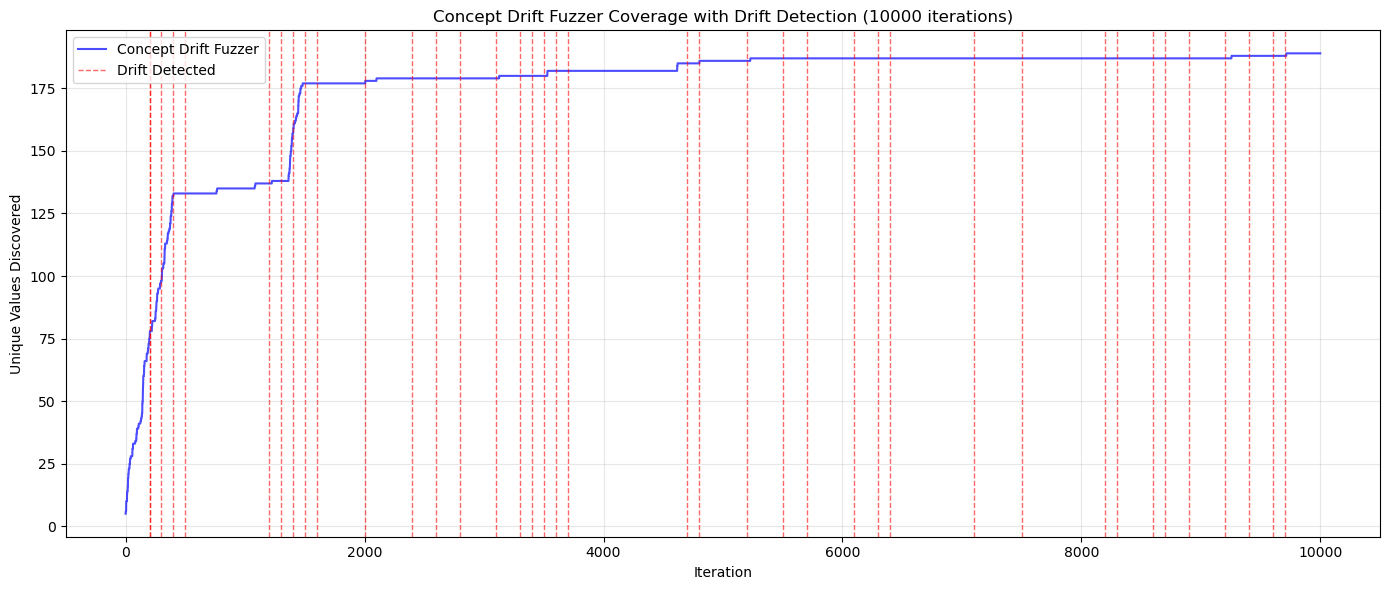


Total drifts detected: 38


In [495]:
# Plot concept drift fuzzer coverage with drift markers
plt.figure(figsize=(14, 6))
plt.plot(cd_coverage, label='Concept Drift Fuzzer', color='blue', alpha=0.7)

# Mark drift detection points with red dotted vertical lines
for drift_iter in drift_fuzzer.sudden_drift_detected_at:
    plt.axvline(x=drift_iter, color='red', linestyle='--', alpha=0.6, linewidth=1)

# Add a legend entry for drift markers
if len(drift_fuzzer.sudden_drift_detected_at) > 0:
    plt.axvline(x=drift_fuzzer.sudden_drift_detected_at[0], color='red', linestyle='--', 
                alpha=0.6, linewidth=1, label='Drift Detected')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer Coverage with Drift Detection ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal drifts detected: {len(drift_fuzzer.sudden_drift_detected_at)}")


In [496]:
# Run concept drift fuzzer with corpus reset on drift
print("Running concept drift fuzzer with reset_on_drift=True...")
random.seed(RANDOM_SEED)
drift_fuzzer_reset = ConceptDriftFuzzer(reset_on_drift=True)
cd_reset_unique_values, cd_reset_coverage = drift_fuzzer_reset.fuzz(ITERS)

print(f"\nConcept Drift Fuzzer (with reset) Results:")
print(f"Total unique values: {len(cd_reset_unique_values)}")
print(f"Final coverage: {cd_reset_coverage[-1]}")
print(f"Corpus size: {len(drift_fuzzer_reset.corpus)}")
print(f"Drifts detected: {len(drift_fuzzer_reset.sudden_drift_detected_at)}")
print(f"Drift iterations: {drift_fuzzer_reset.sudden_drift_detected_at[:10]}..." if len(drift_fuzzer_reset.sudden_drift_detected_at) > 10 else f"Drift iterations: {drift_fuzzer_reset.sudden_drift_detected_at}")

Running concept drift fuzzer with reset_on_drift=True...
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
  -> Corpus reset (cleared 34 entries)
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1182, p-value = 0.0000
  -> Corpus reset (cleared 14 entries)
[Sudden Drift Detected] Iteration 400: KS statistic = 0.4136, p-value = 0.0000
  -> Corpus reset (cleared 23 entries)
[Sudden Drift Detected] Iteration 500: KS statistic = 0.0791, p-value = 0.0020
  -> Corpus reset (cleared 12 entries)
[Sudden Drift Detected] Iteration 600: KS statistic = 0.1055, p-value = 0.0000
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 700: KS statistic = 0.2209, p-value = 0.0000
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 900: KS statistic = 0.0736, p-value = 0.0051
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.0891, p-value = 0.0003
  -> Corpus reset (cleared 0 entries)
[S

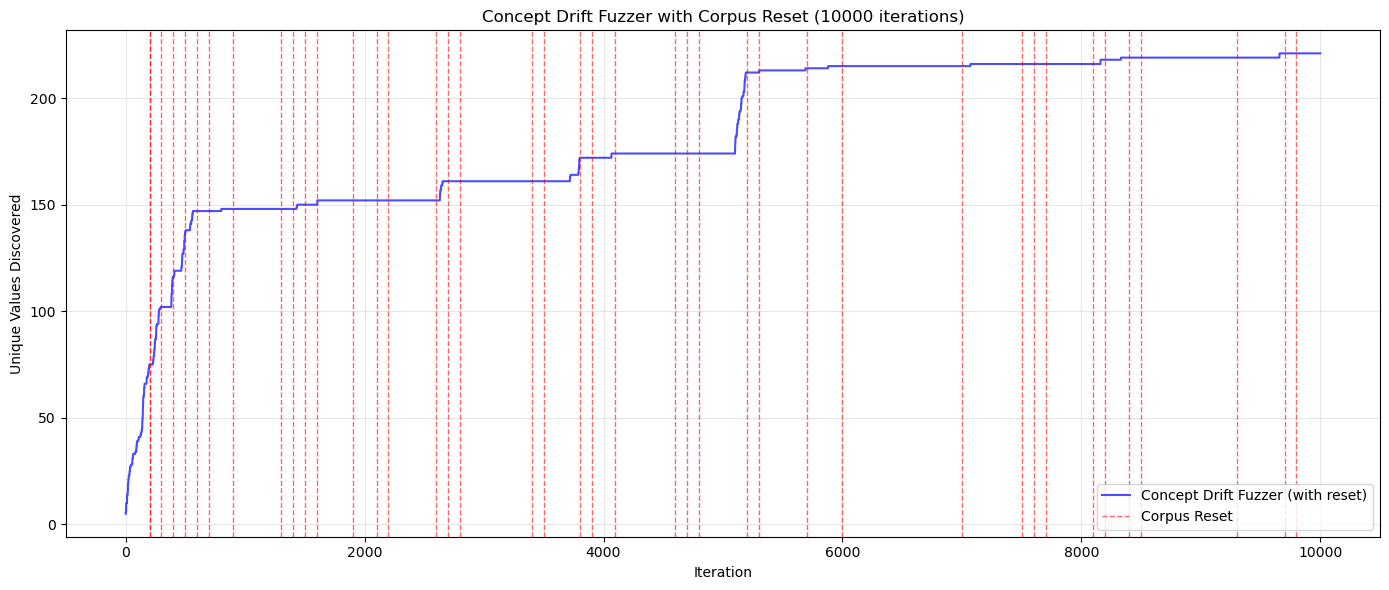


Total corpus resets: 40
Reset iterations: [200, 300, 400, 500, 600, 700, 900, 1300, 1400, 1500, 1600, 1900, 2100, 2200, 2600, 2700, 2800, 3400, 3500, 3800, 3900, 4100, 4600, 4700, 4800, 5200, 5300, 5700, 6000, 7000, 7500, 7600, 7700, 8100, 8200, 8400, 8500, 9300, 9700, 9800]


In [497]:
# Plot concept drift fuzzer with reset enabled and mark reset points
plt.figure(figsize=(14, 6))
plt.plot(cd_reset_coverage, label='Concept Drift Fuzzer (with reset)', color='blue', alpha=0.7)

# Mark corpus reset points with red dotted vertical lines
for reset_iter in drift_fuzzer_reset.corpus_reset_at:
    plt.axvline(x=reset_iter, color='red', linestyle='--', alpha=0.6, linewidth=1)

# Add a legend entry for reset markers
if len(drift_fuzzer_reset.corpus_reset_at) > 0:
    plt.axvline(x=drift_fuzzer_reset.corpus_reset_at[0], color='red', linestyle='--', 
                alpha=0.6, linewidth=1, label='Corpus Reset')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer with Corpus Reset ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal corpus resets: {len(drift_fuzzer_reset.corpus_reset_at)}")
print(f"Reset iterations: {drift_fuzzer_reset.corpus_reset_at}")

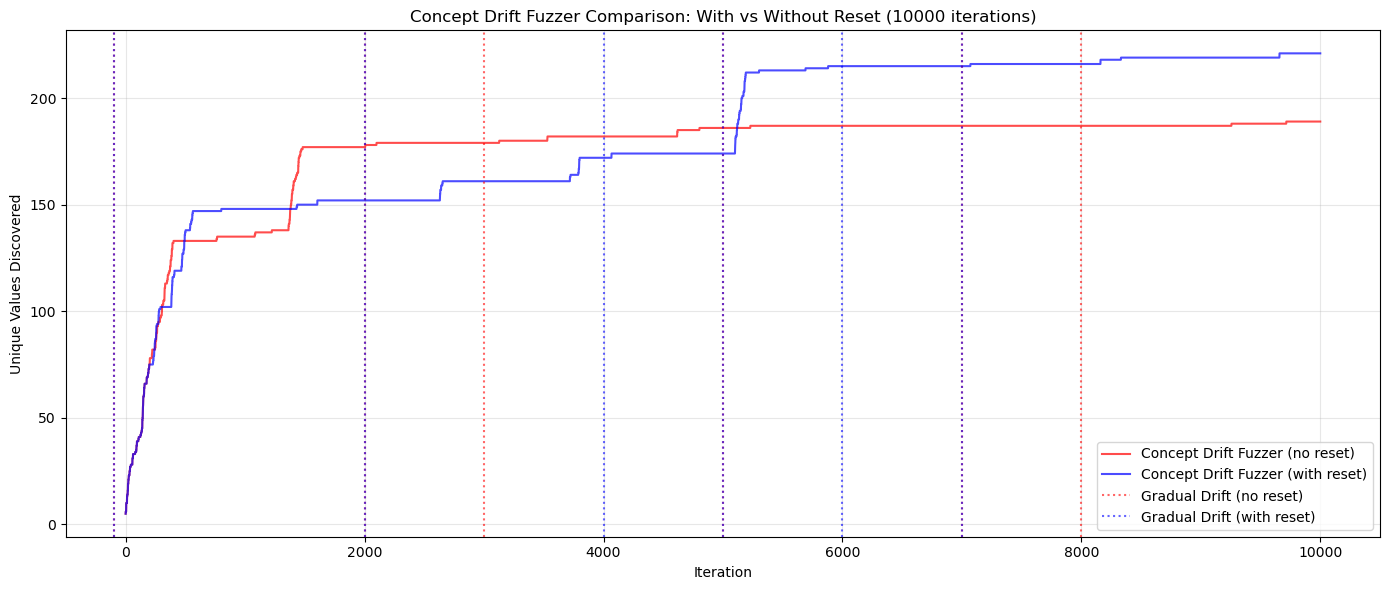


Comparison Summary:
No Reset - Final coverage: 189, Sudden drifts: 38, Gradual drifts: 5
With Reset - Final coverage: 221, Resets performed: 40, Gradual drifts: 5
Difference: 32 unique values (16.93%)


In [498]:
# Compare concept drift fuzzers with and without reset
plt.figure(figsize=(14, 6))
plt.plot(cd_coverage, label='Concept Drift Fuzzer (no reset)', color='red', alpha=0.7)
plt.plot(cd_reset_coverage, label='Concept Drift Fuzzer (with reset)', color='blue', alpha=0.7)

# Mark gradual drift points for no-reset fuzzer with red dotted lines
for drift_iter in drift_fuzzer.gradual_drift_detected_at:
    plt.axvline(x=drift_iter, color='red', linestyle=':', alpha=0.6, linewidth=1.5)

# Mark gradual drift points for with-reset fuzzer with blue dotted lines
for drift_iter in drift_fuzzer_reset.gradual_drift_detected_at:
    plt.axvline(x=drift_iter, color='blue', linestyle=':', alpha=0.6, linewidth=1.5)

# Add legend entries for gradual drift markers
if len(drift_fuzzer.gradual_drift_detected_at) > 0:
    plt.axvline(x=-100, color='red', linestyle=':', alpha=0.6, linewidth=1.5, label='Gradual Drift (no reset)')
if len(drift_fuzzer_reset.gradual_drift_detected_at) > 0:
    plt.axvline(x=-100, color='blue', linestyle=':', alpha=0.6, linewidth=1.5, label='Gradual Drift (with reset)')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer Comparison: With vs Without Reset ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComparison Summary:")
print(f"No Reset - Final coverage: {cd_coverage[-1]}, Sudden drifts: {len(drift_fuzzer.sudden_drift_detected_at)}, Gradual drifts: {len(drift_fuzzer.gradual_drift_detected_at)}")
print(f"With Reset - Final coverage: {cd_reset_coverage[-1]}, Resets performed: {len(drift_fuzzer_reset.corpus_reset_at)}, Gradual drifts: {len(drift_fuzzer_reset.gradual_drift_detected_at)}")
print(f"Difference: {cd_reset_coverage[-1] - cd_coverage[-1]} unique values ({((cd_reset_coverage[-1] - cd_coverage[-1]) / cd_coverage[-1] * 100):.2f}%)")

In [499]:
class ConceptDriftFuzzerV2:
    """Coverage-guided fuzzer with KS drift detection (V2 for analysis)."""
    
    def __init__(self, num_mutations: int = NUM_MUTATIONS, 
                 sudden_drift_window: int = SUDDEN_DRIFT_WINDOW,
                 gradual_drift_window: int = GRADUAL_DRIFT_WINDOW,
                 drift_threshold: float = DRIFT_THRESHOLD,
                 saturation_threshold: float = SATURATION_THRESHOLD,
                 breakthrough_threshold: float = BREAKTHROUGH_THRESHOLD,
                 reset_on_drift: bool = False,
                 reset_on_saturation: bool = False,
                 track_coverage_rate: bool = False,
                 track_corpus_size: bool = False,
                 classify_drift_type: bool = False):
        self.num_mutations = num_mutations
        self.sudden_drift_window = sudden_drift_window
        self.gradual_drift_window = gradual_drift_window
        self.drift_threshold = drift_threshold
        self.saturation_threshold = saturation_threshold
        self.breakthrough_threshold = breakthrough_threshold
        self.reset_on_drift = reset_on_drift
        self.reset_on_saturation = reset_on_saturation
        
        # Analysis feature flags
        self.track_coverage_rate = track_coverage_rate
        self.track_corpus_size = track_corpus_size
        self.classify_drift_type = classify_drift_type
        
        self.unique_values: set[int] = set()
        self.coverage: list[int] = []
        self.corpus: list[list[Operation]] = []
        self.calc = Calculator()
        
        # Drift detection tracking
        self.values_window: list[list[int]] = []  # Store logs for each iteration
        self.sudden_drift_detected_at: list[int] = []  # Iterations where sudden drift was detected
        self.gradual_drift_detected_at: list[int] = []  # Iterations where gradual drift was detected
        self.ks_statistics: list[float] = []  # KS statistic at each check
        self.corpus_reset_at: list[int] = []  # Iterations where corpus was reset
        
        # Analysis metrics (only populated if flags are enabled)
        self.coverage_growth_rates: list[tuple[int, float]] = []  # (iteration, growth_rate)
        self.corpus_sizes_at_drift: list[tuple[int, int]] = []  # (iteration, corpus_size)
        self.drift_classifications: list[tuple[int, str]] = []  # (iteration, "saturation" or "breakthrough")
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """
        Run the fuzzer for the specified number of iterations.
        Monitors for concept drift using KS test.
        
        Returns:
            tuple of (unique_values, coverage_over_time)
        """
        for i in range(iters):
            # Queue-based selection: pick next item from queue, or generate random if empty
            if self.corpus:
                ops = self.corpus.pop(0)
            else:
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # Store values for drift detection
            self.values_window.append(log)
            
            # Check for sudden drift every sudden_drift_window iterations
            if i > 0 and i % self.sudden_drift_window == 0 and len(self.values_window) >= 2 * self.sudden_drift_window:
                self._check_drift(i, drift_type='sudden')
            
            # Check for gradual drift every gradual_drift_window iterations
            if i > 0 and i % self.gradual_drift_window == 0 and len(self.values_window) >= 2 * self.gradual_drift_window:
                self._check_drift(i, drift_type='gradual')
            
            # If this sequence found new values, add multiple mutations to corpus
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage
    
    def _check_drift(self, iteration: int, drift_type: str):
        """Check for concept drift using KS test."""
        # Select window size based on drift type
        window_size = self.sudden_drift_window if drift_type == 'sudden' else self.gradual_drift_window
        
        # Get the previous window and current window
        prev_window_start = max(0, len(self.values_window) - 2 * window_size)
        prev_window_end = len(self.values_window) - window_size
        curr_window_start = len(self.values_window) - window_size
        
        # Flatten the logs into distributions
        prev_values = [val for log in self.values_window[prev_window_start:prev_window_end] for val in log]
        curr_values = [val for log in self.values_window[curr_window_start:] for val in log]
        
        if len(prev_values) > 0 and len(curr_values) > 0:
            # Perform KS test
            ks_stat, p_value = ks_2samp(prev_values, curr_values)
            self.ks_statistics.append(ks_stat)
            
            # Detect drift if p-value is below threshold
            if p_value < self.drift_threshold:
                if drift_type == 'sudden':
                    self.sudden_drift_detected_at.append(iteration)
                    
                    # Analyze drift characteristics for sudden drifts only
                    classification = self._analyze_drift(iteration, window_size)
                    
                    print(f"[Sudden Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
                    
                    # Reset corpus on sudden drift if enabled
                    if self.reset_on_drift:
                        corpus_size = len(self.corpus)
                        self.corpus = []
                        self.corpus_reset_at.append(iteration)
                        print(f"  -> Corpus reset (cleared {corpus_size} entries)")
                    
                    # Reset corpus only on saturation drift if enabled
                    elif self.reset_on_saturation and classification == 'saturation':
                        corpus_size = len(self.corpus)
                        self.corpus = []
                        self.corpus_reset_at.append(iteration)
                        print(f"  -> Corpus reset due to saturation (cleared {corpus_size} entries)")
                else:
                    self.gradual_drift_detected_at.append(iteration)
                    print(f"[Gradual Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
    
    def _analyze_drift(self, iteration: int, window_size: int) -> str:
        """Analyze drift characteristics at detection time (only for sudden drifts).
        
        Returns:
            Classification string: 'saturation', 'breakthrough', 'neutral', or 'unknown'
        """
        
        # Classify drift type first (always needed for reset_on_saturation)
        classification = self._classify_drift(iteration, window_size)
        
        # Track coverage growth rate if enabled
        if self.track_coverage_rate:
            # Calculate coverage growth rate in the window before drift
            lookback_start = max(0, iteration - window_size)
            if lookback_start < len(self.coverage):
                coverage_before = self.coverage[lookback_start]
                coverage_at_drift = self.coverage[iteration - 1] if iteration > 0 else 0
                growth_rate = (coverage_at_drift - coverage_before) / window_size if window_size > 0 else 0
                self.coverage_growth_rates.append((iteration, growth_rate))
        
        # Track corpus size if enabled
        if self.track_corpus_size:
            self.corpus_sizes_at_drift.append((iteration, len(self.corpus)))
        
        # Classify drift type if enabled
        if self.classify_drift_type:
            self.drift_classifications.append((iteration, classification))
            print(f"  -> Drift classification: {classification}")
        
        return classification
    
    def _classify_drift(self, iteration: int, window_size: int) -> str:
        """
        Classify drift as 'saturation' or 'breakthrough' based on coverage trends.
        
        Saturation: Coverage growth is slowing down (plateau)
        Breakthrough: Coverage growth is accelerating (new regions discovered)
        """
        # Need at least 2 windows of data to compare growth rates
        if iteration < 2 * window_size:
            return "unknown"
        
        # Calculate growth rate in previous window
        prev_start = max(0, iteration - 2 * window_size)
        prev_end = iteration - window_size
        prev_coverage_start = self.coverage[prev_start] if prev_start < len(self.coverage) else 0
        prev_coverage_end = self.coverage[prev_end] if prev_end < len(self.coverage) else 0
        prev_growth_rate = (prev_coverage_end - prev_coverage_start) / window_size
        
        # Calculate growth rate in current window
        curr_start = iteration - window_size
        curr_end = iteration - 1
        curr_coverage_start = self.coverage[curr_start] if curr_start < len(self.coverage) else 0
        curr_coverage_end = self.coverage[curr_end] if curr_end < len(self.coverage) else 0
        curr_growth_rate = (curr_coverage_end - curr_coverage_start) / window_size
        
        # Classification logic using configurable thresholds
        # Saturation: current growth rate significantly lower than previous
        # Breakthrough: current growth rate significantly higher than previous
        if curr_growth_rate < prev_growth_rate * self.saturation_threshold:
            return "saturation"
        elif curr_growth_rate > prev_growth_rate * self.breakthrough_threshold:
            return "breakthrough"
        else:
            return "neutral"
    
    def mutate_operations(self, ops: list[Operation]) -> list[Operation]:
        """Mutate an operation sequence by changing or swapping operations (constant length)."""
        ops = ops.copy()
        mutation_type = random.choice(['change', 'swap'])
        
        if mutation_type == 'change' and len(ops) > 0:
            idx = random.randint(0, len(ops) - 1)
            ops[idx] = random.choice(list(Operation))
        
        elif mutation_type == 'swap' and len(ops) > 1:
            idx1 = random.randint(0, len(ops) - 1)
            idx2 = random.randint(0, len(ops) - 1)
            ops[idx1], ops[idx2] = ops[idx2], ops[idx1]
        
        return ops

In [500]:
# Run ConceptDriftFuzzerV2 with all analysis features enabled
print("Running ConceptDriftFuzzerV2 with full analysis...")
random.seed(RANDOM_SEED)
fuzzer_v2 = ConceptDriftFuzzerV2(
    track_coverage_rate=True,
    track_corpus_size=True,
    classify_drift_type=True
)
v2_unique_values, v2_coverage = fuzzer_v2.fuzz(ITERS)

print(f"\nConceptDriftFuzzerV2 Results:")
print(f"Total unique values: {len(v2_unique_values)}")
print(f"Final coverage: {v2_coverage[-1]}")
print(f"Corpus size: {len(fuzzer_v2.corpus)}")
print(f"Sudden drifts detected: {len(fuzzer_v2.sudden_drift_detected_at)}")
print(f"Gradual drifts detected: {len(fuzzer_v2.gradual_drift_detected_at)}")

print(f"\n--- Drift Classifications ---")
for iteration, classification in fuzzer_v2.drift_classifications:
    print(f"  Iteration {iteration}: {classification}")

print(f"\n--- Coverage Growth Rates at Drift ---")
for iteration, growth_rate in fuzzer_v2.coverage_growth_rates:
    print(f"  Iteration {iteration}: {growth_rate:.4f} values/iter")

print(f"\n--- Corpus Sizes at Drift ---")
for iteration, corpus_size in fuzzer_v2.corpus_sizes_at_drift:
    print(f"  Iteration {iteration}: {corpus_size} entries")

Running ConceptDriftFuzzerV2 with full analysis...
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
  -> Drift classification: saturation
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
  -> Drift classification: saturation
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
  -> Drift classification: breakthrough
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
  -> Drift classification: breakthrough
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 1500: KS statistic = 0.3200, p-value = 0.0000
  -> Drift classi

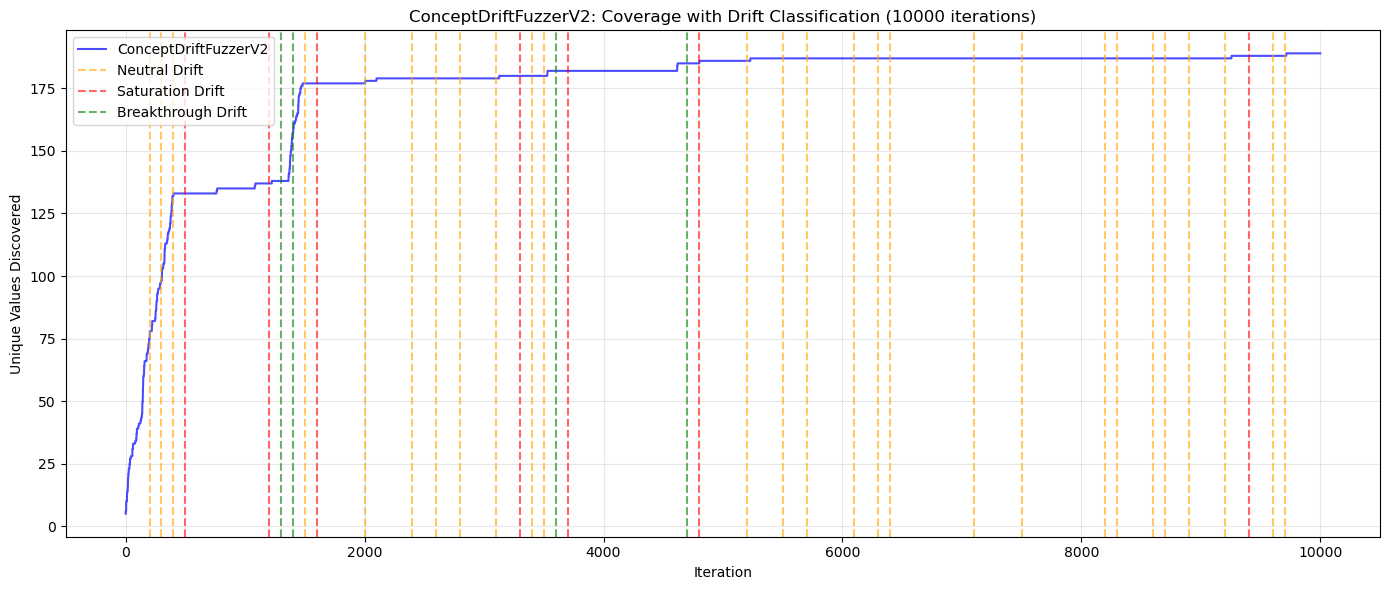


Drift Classification Summary:
  Saturation: 7
  Breakthrough: 4
  Neutral: 27


In [501]:
# Plot ConceptDriftFuzzerV2 with drift classifications
plt.figure(figsize=(14, 6))
plt.plot(v2_coverage, label='ConceptDriftFuzzerV2', color='blue', alpha=0.7)

# Mark drifts with different colors based on classification
# Create dictionaries to track which markers we've added to legend
added_saturation = False
added_breakthrough = False
added_neutral = False

for iteration, classification in fuzzer_v2.drift_classifications:
    if classification == 'saturation':
        label = 'Saturation Drift' if not added_saturation else None
        plt.axvline(x=iteration, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label=label)
        added_saturation = True
    elif classification == 'breakthrough':
        label = 'Breakthrough Drift' if not added_breakthrough else None
        plt.axvline(x=iteration, color='green', linestyle='--', alpha=0.6, linewidth=1.5, label=label)
        added_breakthrough = True
    elif classification == 'neutral':
        label = 'Neutral Drift' if not added_neutral else None
        plt.axvline(x=iteration, color='orange', linestyle='--', alpha=0.6, linewidth=1.5, label=label)
        added_neutral = True

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'ConceptDriftFuzzerV2: Coverage with Drift Classification ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary of drift classifications
print(f"\nDrift Classification Summary:")
saturation_count = sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'saturation')
breakthrough_count = sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'breakthrough')
neutral_count = sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'neutral')
print(f"  Saturation: {saturation_count}")
print(f"  Breakthrough: {breakthrough_count}")
print(f"  Neutral: {neutral_count}")

In [504]:
# Run ConceptDriftFuzzerV2 with reset_on_saturation enabled
print("Running ConceptDriftFuzzerV2 with reset_on_saturation=True...")
random.seed(RANDOM_SEED)
fuzzer_v2_saturation_reset = ConceptDriftFuzzerV2(
    track_coverage_rate=True,
    track_corpus_size=True,
    classify_drift_type=True,
    reset_on_saturation=True
)
v2_sat_reset_unique_values, v2_sat_reset_coverage = fuzzer_v2_saturation_reset.fuzz(ITERS)

print(f"\nConceptDriftFuzzerV2 (with saturation reset) Results:")
print(f"Total unique values: {len(v2_sat_reset_unique_values)}")
print(f"Final coverage: {v2_sat_reset_coverage[-1]}")
print(f"Corpus size: {len(fuzzer_v2_saturation_reset.corpus)}")
print(f"Sudden drifts detected: {len(fuzzer_v2_saturation_reset.sudden_drift_detected_at)}")
print(f"Corpus resets performed: {len(fuzzer_v2_saturation_reset.corpus_reset_at)}")
print(f"Reset iterations: {fuzzer_v2_saturation_reset.corpus_reset_at}")

print(f"\n--- Drift Classifications ---")
for iteration, classification in fuzzer_v2_saturation_reset.drift_classifications:
    reset_marker = " [RESET]" if iteration in fuzzer_v2_saturation_reset.corpus_reset_at else ""
    print(f"  Iteration {iteration}: {classification}{reset_marker}")

Running ConceptDriftFuzzerV2 with reset_on_saturation=True...
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
  -> Drift classification: neutral
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
  -> Drift classification: saturation
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
  -> Corpus reset due to saturation (cleared 0 entries)
  -> Drift classification: saturation
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
  -> Corpus reset due to saturation (cleared 0 entries)
  -> Drift classification: breakthrough
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
  -> Drift classification: breakthrough
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
  -> Drif

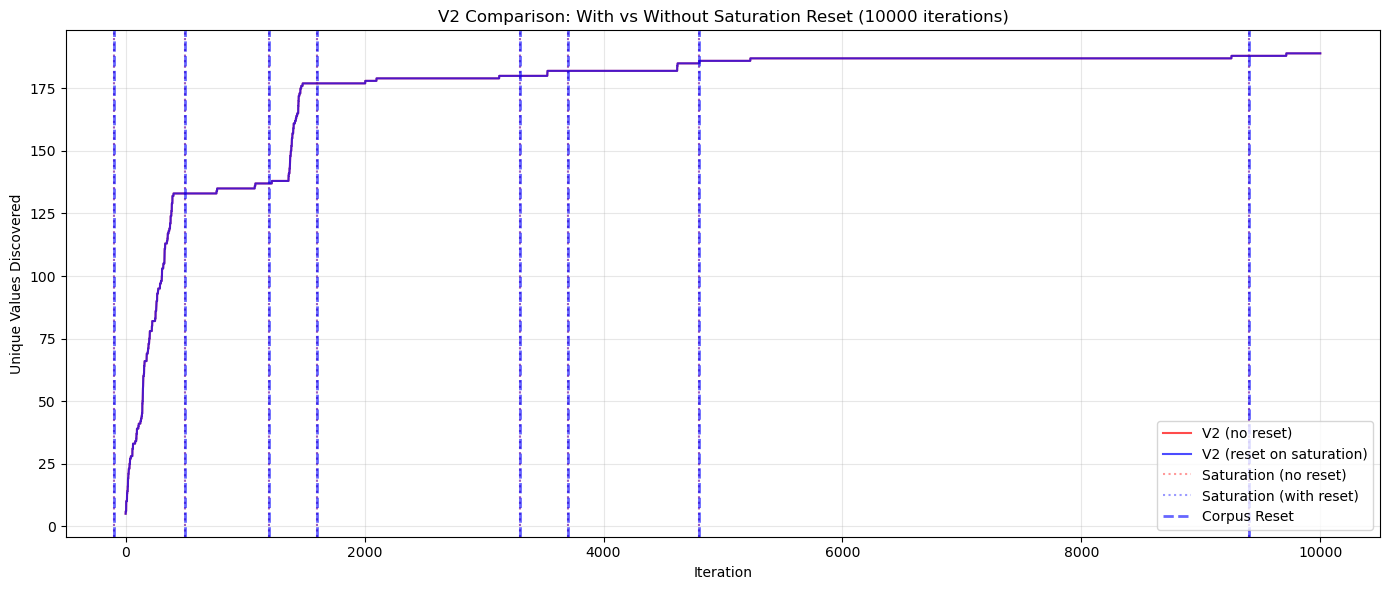


Comparison Summary:
No Reset - Final coverage: 189, Saturation drifts: 7
Saturation Reset - Final coverage: 189, Resets: 7
Difference: 0 unique values (0.00%)


In [503]:
# Compare V2 with and without saturation reset
plt.figure(figsize=(14, 6))
plt.plot(v2_coverage, label='V2 (no reset)', color='red', alpha=0.7)
plt.plot(v2_sat_reset_coverage, label='V2 (reset on saturation)', color='blue', alpha=0.7)

# Mark saturation drifts for no-reset fuzzer (red dotted)
for iteration, classification in fuzzer_v2.drift_classifications:
    if classification == 'saturation':
        plt.axvline(x=iteration, color='red', linestyle=':', alpha=0.4, linewidth=1.5)

# Mark saturation drifts for saturation-reset fuzzer (blue dotted)
# and corpus resets (blue dashed)
for iteration, classification in fuzzer_v2_saturation_reset.drift_classifications:
    if classification == 'saturation':
        plt.axvline(x=iteration, color='blue', linestyle=':', alpha=0.4, linewidth=1.5)

for reset_iter in fuzzer_v2_saturation_reset.corpus_reset_at:
    plt.axvline(x=reset_iter, color='blue', linestyle='--', alpha=0.6, linewidth=2)

# Add legend entries
if len(fuzzer_v2.drift_classifications) > 0:
    plt.axvline(x=-100, color='red', linestyle=':', alpha=0.4, linewidth=1.5, label='Saturation (no reset)')
if len(fuzzer_v2_saturation_reset.drift_classifications) > 0:
    plt.axvline(x=-100, color='blue', linestyle=':', alpha=0.4, linewidth=1.5, label='Saturation (with reset)')
if len(fuzzer_v2_saturation_reset.corpus_reset_at) > 0:
    plt.axvline(x=-100, color='blue', linestyle='--', alpha=0.6, linewidth=2, label='Corpus Reset')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'V2 Comparison: With vs Without Saturation Reset ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComparison Summary:")
print(f"No Reset - Final coverage: {v2_coverage[-1]}, Saturation drifts: {sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'saturation')}")
print(f"Saturation Reset - Final coverage: {v2_sat_reset_coverage[-1]}, Resets: {len(fuzzer_v2_saturation_reset.corpus_reset_at)}")
print(f"Difference: {v2_sat_reset_coverage[-1] - v2_coverage[-1]} unique values ({((v2_sat_reset_coverage[-1] - v2_coverage[-1]) / v2_coverage[-1] * 100):.2f}%)")

In [505]:
# Analyze corpus sizes at drift detection points
print("Corpus Size Analysis at Drift Points:\n")
print("No Reset Fuzzer:")
for iteration, corpus_size in fuzzer_v2.corpus_sizes_at_drift:
    classification = next((c for i, c in fuzzer_v2.drift_classifications if i == iteration), "unknown")
    print(f"  Iteration {iteration:5d}: corpus_size={corpus_size:4d}, classification={classification}")

print("\n\nWith Saturation Reset Fuzzer:")
for iteration, corpus_size in fuzzer_v2_saturation_reset.corpus_sizes_at_drift:
    classification = next((c for i, c in fuzzer_v2_saturation_reset.drift_classifications if i == iteration), "unknown")
    was_reset = "[RESET]" if iteration in fuzzer_v2_saturation_reset.corpus_reset_at else ""
    print(f"  Iteration {iteration:5d}: corpus_size={corpus_size:4d}, classification={classification} {was_reset}")

print("\n\nKey Insight:")
print(f"Average corpus size at saturation drifts (no reset): {sum(cs for it, cs in fuzzer_v2.corpus_sizes_at_drift if any(i == it and c == 'saturation' for i, c in fuzzer_v2.drift_classifications)) / max(1, sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'saturation')):.1f}")
print(f"Average corpus size at breakthrough drifts (no reset): {sum(cs for it, cs in fuzzer_v2.corpus_sizes_at_drift if any(i == it and c == 'breakthrough' for i, c in fuzzer_v2.drift_classifications)) / max(1, sum(1 for _, c in fuzzer_v2.drift_classifications if c == 'breakthrough')):.1f}")

Corpus Size Analysis at Drift Points:

No Reset Fuzzer:
  Iteration   200: corpus_size=  34, classification=neutral
  Iteration   300: corpus_size=   9, classification=neutral
  Iteration   400: corpus_size=   0, classification=neutral
  Iteration   500: corpus_size=   0, classification=saturation
  Iteration  1200: corpus_size=   0, classification=saturation
  Iteration  1300: corpus_size=   0, classification=breakthrough
  Iteration  1400: corpus_size=  29, classification=breakthrough
  Iteration  1500: corpus_size=   0, classification=neutral
  Iteration  1600: corpus_size=   0, classification=saturation
  Iteration  2000: corpus_size=   0, classification=neutral
  Iteration  2400: corpus_size=   0, classification=neutral
  Iteration  2600: corpus_size=   0, classification=neutral
  Iteration  2800: corpus_size=   0, classification=neutral
  Iteration  3100: corpus_size=   0, classification=neutral
  Iteration  3300: corpus_size=   0, classification=saturation
  Iteration  3400: cor

## Phase 1: Parameter Tuning & Quick Wins

Now let's experiment with simple improvements:
1. **Increase NUM_MUTATIONS**: More mutations per coverage → longer corpus lifetime
2. **Minimum Corpus**: Keep a seed pool to prevent complete depletion
3. **Diversity Injection**: Periodically inject random inputs for exploration

In [506]:
# Experiment 1: Test different NUM_MUTATIONS values
# Run multiple fuzzers with different mutation rates and compare corpus lifetime

print("=" * 80)
print("EXPERIMENT 1: Impact of NUM_MUTATIONS on Corpus Lifetime")
print("=" * 80)

mutation_rates = [5, 10, 20, 50]
results = {}

for num_mut in mutation_rates:
    print(f"\n--- Testing NUM_MUTATIONS = {num_mut} ---")
    random.seed(RANDOM_SEED)
    
    fuzzer_test = ConceptDriftFuzzerV2(
        num_mutations=num_mut,
        track_corpus_size=True,
        classify_drift_type=False  # Disable to reduce output
    )
    
    test_unique_values, test_coverage = fuzzer_test.fuzz(ITERS)
    
    # Track corpus size over time
    corpus_sizes = [size for _, size in fuzzer_test.corpus_sizes_at_drift]
    
    # Find when corpus hits 0 permanently
    corpus_zero_iter = None
    for i, (iteration, size) in enumerate(fuzzer_test.corpus_sizes_at_drift):
        if size == 0:
            # Check if all subsequent are also 0
            if all(s == 0 for _, s in fuzzer_test.corpus_sizes_at_drift[i:]):
                corpus_zero_iter = iteration
                break
    
    results[num_mut] = {
        'final_coverage': test_coverage[-1],
        'corpus_zero_at': corpus_zero_iter,
        'avg_corpus_size': sum(corpus_sizes) / len(corpus_sizes) if corpus_sizes else 0,
        'max_corpus_size': max(corpus_sizes) if corpus_sizes else 0,
        'coverage_data': test_coverage
    }
    
    print(f"  Final Coverage: {test_coverage[-1]}")
    print(f"  Corpus depleted at iteration: {corpus_zero_iter if corpus_zero_iter else 'Never (or after last drift check)'}")
    print(f"  Average corpus size at drifts: {results[num_mut]['avg_corpus_size']:.1f}")
    print(f"  Max corpus size: {results[num_mut]['max_corpus_size']}")

print("\n" + "=" * 80)
print("SUMMARY: NUM_MUTATIONS Impact")
print("=" * 80)
for num_mut in mutation_rates:
    r = results[num_mut]
    print(f"NUM_MUTATIONS={num_mut:2d}: Coverage={r['final_coverage']:3d}, "
          f"Corpus depleted@{str(r['corpus_zero_at']):5s}, "
          f"Avg size={r['avg_corpus_size']:5.1f}, Max={r['max_corpus_size']:3d}")

EXPERIMENT 1: Impact of NUM_MUTATIONS on Corpus Lifetime

--- Testing NUM_MUTATIONS = 5 ---
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
[Sudden Drift Detected] Iteration 1500: KS statistic = 0.3200, p-value = 0.0000
[Sudden Drift Detected] Iteration 1600: KS statistic = 0.5591, p-value = 0.0000
[Sudden Drift Detected] Iteration 2000: KS statistic = 0.0591, p-value = 0.0429
[Gradual Drift Detected] Iteration 2000: KS statistic = 0.1631, p-value = 0.0000
[Sudden Drift Detected] Iterati

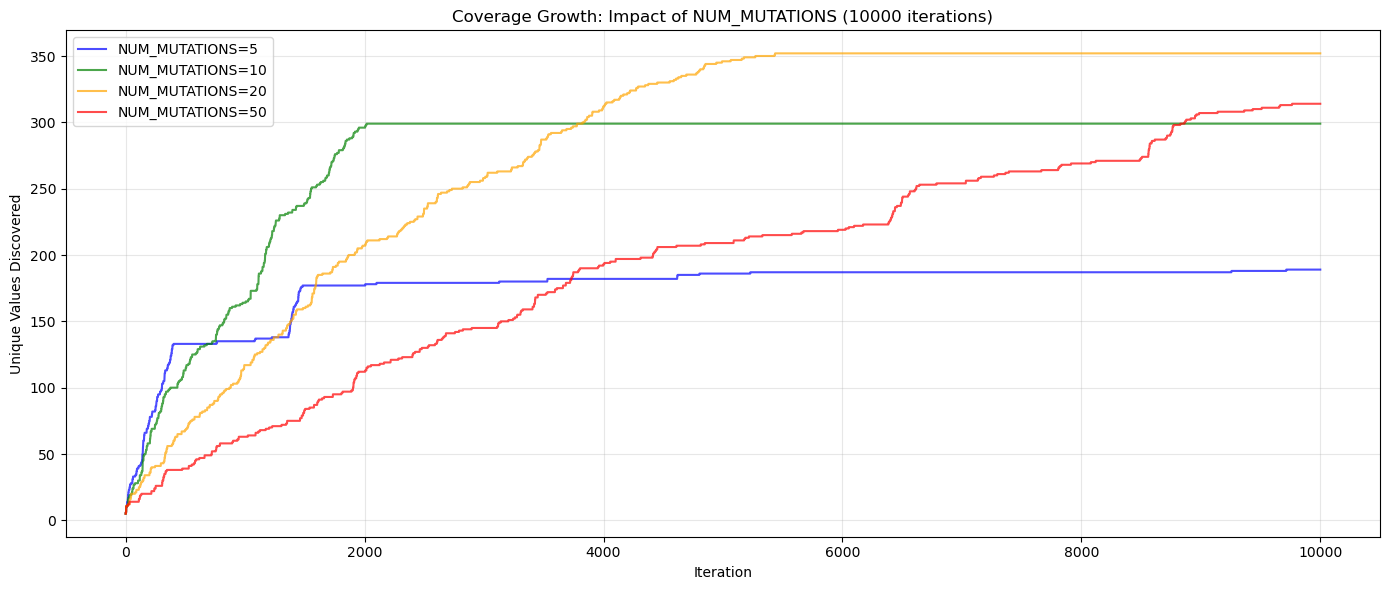


Key Insight:
Baseline (NUM_MUTATIONS=5): 189 coverage
NUM_MUTATIONS=10: 299 coverage (+110, +58.2%)
NUM_MUTATIONS=20: 352 coverage (+163, +86.2%)
NUM_MUTATIONS=50: 314 coverage (+125, +66.1%)


In [507]:
# Visualize Experiment 1 results
plt.figure(figsize=(14, 6))

colors = ['blue', 'green', 'orange', 'red']
for (num_mut, color) in zip(mutation_rates, colors):
    plt.plot(results[num_mut]['coverage_data'], 
             label=f'NUM_MUTATIONS={num_mut}', 
             color=color, alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Coverage Growth: Impact of NUM_MUTATIONS ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print(f"Baseline (NUM_MUTATIONS=5): {results[5]['final_coverage']} coverage")
for num_mut in [10, 20, 50]:
    improvement = results[num_mut]['final_coverage'] - results[5]['final_coverage']
    pct = (improvement / results[5]['final_coverage'] * 100) if results[5]['final_coverage'] > 0 else 0
    print(f"NUM_MUTATIONS={num_mut}: {results[num_mut]['final_coverage']} coverage ({improvement:+d}, {pct:+.1f}%)")

In [508]:
# Quick Win 1: Fuzzer with Minimum Corpus (Seed Pool)
# Prevents corpus from being completely depleted

class MinCorpusFuzzer(ConceptDriftFuzzerV2):
    """Fuzzer that maintains a minimum corpus size by keeping a seed pool."""
    
    def __init__(self, min_corpus_size: int = 10, **kwargs):
        super().__init__(**kwargs)
        self.min_corpus_size = min_corpus_size
        self.seed_pool: list[list[Operation]] = []  # Best inputs kept as seeds
        self.corpus_refills: list[int] = []  # Track when we refilled corpus
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """Run fuzzer with minimum corpus guarantee."""
        for i in range(iters):
            # Check if corpus needs refilling
            if len(self.corpus) < self.min_corpus_size and len(self.seed_pool) > 0:
                # Refill from seed pool
                needed = self.min_corpus_size - len(self.corpus)
                for _ in range(needed):
                    seed = random.choice(self.seed_pool)
                    self.corpus.append(self.mutate_operations(seed))
                self.corpus_refills.append(i)
            
            # Queue-based selection
            if self.corpus:
                ops = self.corpus.pop(0)
            else:
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # Store values for drift detection
            self.values_window.append(log)
            
            # Check for drifts
            if i > 0 and i % self.sudden_drift_window == 0 and len(self.values_window) >= 2 * self.sudden_drift_window:
                self._check_drift(i, drift_type='sudden')
            
            if i > 0 and i % self.gradual_drift_window == 0 and len(self.values_window) >= 2 * self.gradual_drift_window:
                self._check_drift(i, drift_type='gradual')
            
            # If new coverage found
            if new_coverage > old_coverage:
                # Add to corpus
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
                
                # Add to seed pool (keep best diverse inputs)
                self.seed_pool.append(ops)
                # Limit seed pool size
                if len(self.seed_pool) > self.min_corpus_size * 2:
                    self.seed_pool.pop(0)
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage

print("MinCorpusFuzzer class created successfully!")

MinCorpusFuzzer class created successfully!


In [509]:
# Test MinCorpusFuzzer
print("=" * 80)
print("QUICK WIN 1: Minimum Corpus with Seed Pool")
print("=" * 80)

random.seed(RANDOM_SEED)
min_corpus_fuzzer = MinCorpusFuzzer(
    min_corpus_size=10,
    track_corpus_size=True,
    classify_drift_type=False
)

min_corpus_unique, min_corpus_coverage = min_corpus_fuzzer.fuzz(ITERS)

print(f"\nMinCorpusFuzzer Results:")
print(f"  Final Coverage: {min_corpus_coverage[-1]}")
print(f"  Corpus refills performed: {len(min_corpus_fuzzer.corpus_refills)}")
print(f"  Seed pool size: {len(min_corpus_fuzzer.seed_pool)}")
print(f"  Final corpus size: {len(min_corpus_fuzzer.corpus)}")

if min_corpus_fuzzer.corpus_refills:
    print(f"  First refill at iteration: {min_corpus_fuzzer.corpus_refills[0]}")
    print(f"  Refill iterations: {min_corpus_fuzzer.corpus_refills[:20]}{'...' if len(min_corpus_fuzzer.corpus_refills) > 20 else ''}")

print(f"\nComparison to Baseline (V2 with NUM_MUTATIONS=5):")
print(f"  Baseline coverage: {v2_coverage[-1]}")
print(f"  MinCorpus coverage: {min_corpus_coverage[-1]}")
print(f"  Improvement: {min_corpus_coverage[-1] - v2_coverage[-1]:+d} ({((min_corpus_coverage[-1] - v2_coverage[-1]) / v2_coverage[-1] * 100):+.1f}%)")

QUICK WIN 1: Minimum Corpus with Seed Pool
[Sudden Drift Detected] Iteration 200: KS statistic = 0.3618, p-value = 0.0000
[Sudden Drift Detected] Iteration 300: KS statistic = 0.0955, p-value = 0.0001
[Sudden Drift Detected] Iteration 400: KS statistic = 0.0627, p-value = 0.0264
[Sudden Drift Detected] Iteration 500: KS statistic = 0.1727, p-value = 0.0000
[Sudden Drift Detected] Iteration 800: KS statistic = 0.1645, p-value = 0.0000
[Sudden Drift Detected] Iteration 900: KS statistic = 0.2618, p-value = 0.0000
[Sudden Drift Detected] Iteration 1000: KS statistic = 0.3009, p-value = 0.0000
[Sudden Drift Detected] Iteration 1100: KS statistic = 0.1800, p-value = 0.0000
[Gradual Drift Detected] Iteration 2000: KS statistic = 0.5934, p-value = 0.0000
[Gradual Drift Detected] Iteration 3000: KS statistic = 0.0253, p-value = 0.0017

MinCorpusFuzzer Results:
  Final Coverage: 314
  Corpus refills performed: 8884
  Seed pool size: 20
  Final corpus size: 9
  First refill at iteration: 1
  Ref

In [510]:
# Quick Win 2: Fuzzer with Periodic Diversity Injection
# Injects random inputs at regular intervals to maintain exploration

class DiversityInjectionFuzzer(ConceptDriftFuzzerV2):
    """Fuzzer that periodically injects random inputs for diversity."""
    
    def __init__(self, injection_interval: int = 500, injection_count: int = 5, **kwargs):
        super().__init__(**kwargs)
        self.injection_interval = injection_interval
        self.injection_count = injection_count
        self.injections_performed: list[int] = []  # Track when we injected
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """Run fuzzer with periodic diversity injection."""
        for i in range(iters):
            # Periodic diversity injection
            if i > 0 and i % self.injection_interval == 0:
                for _ in range(self.injection_count):
                    random_ops = generate_random_operations()
                    self.corpus.append(random_ops)
                self.injections_performed.append(i)
            
            # Queue-based selection
            if self.corpus:
                ops = self.corpus.pop(0)
            else:
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # Store values for drift detection
            self.values_window.append(log)
            
            # Check for drifts
            if i > 0 and i % self.sudden_drift_window == 0 and len(self.values_window) >= 2 * self.sudden_drift_window:
                self._check_drift(i, drift_type='sudden')
            
            if i > 0 and i % self.gradual_drift_window == 0 and len(self.values_window) >= 2 * self.gradual_drift_window:
                self._check_drift(i, drift_type='gradual')
            
            # If new coverage found
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage

print("DiversityInjectionFuzzer class created successfully!")

DiversityInjectionFuzzer class created successfully!


In [511]:
# Test DiversityInjectionFuzzer
print("=" * 80)
print("QUICK WIN 2: Periodic Diversity Injection")
print("=" * 80)

random.seed(RANDOM_SEED)
diversity_fuzzer = DiversityInjectionFuzzer(
    injection_interval=500,
    injection_count=5,
    track_corpus_size=True,
    classify_drift_type=False
)

diversity_unique, diversity_coverage = diversity_fuzzer.fuzz(ITERS)

print(f"\nDiversityInjectionFuzzer Results:")
print(f"  Final Coverage: {diversity_coverage[-1]}")
print(f"  Injections performed: {len(diversity_fuzzer.injections_performed)}")
print(f"  Total inputs injected: {len(diversity_fuzzer.injections_performed) * 5}")
print(f"  Final corpus size: {len(diversity_fuzzer.corpus)}")

if diversity_fuzzer.injections_performed:
    print(f"  Injection iterations: {diversity_fuzzer.injections_performed}")

print(f"\nComparison to Baseline (V2 with NUM_MUTATIONS=5):")
print(f"  Baseline coverage: {v2_coverage[-1]}")
print(f"  Diversity Injection coverage: {diversity_coverage[-1]}")
print(f"  Improvement: {diversity_coverage[-1] - v2_coverage[-1]:+d} ({((diversity_coverage[-1] - v2_coverage[-1]) / v2_coverage[-1] * 100):+.1f}%)")

QUICK WIN 2: Periodic Diversity Injection
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
[Sudden Drift Detected] Iteration 1500: KS statistic = 0.3200, p-value = 0.0000
[Sudden Drift Detected] Iteration 1600: KS statistic = 0.5591, p-value = 0.0000
[Sudden Drift Detected] Iteration 2000: KS statistic = 0.0591, p-value = 0.0429
[Gradual Drift Detected] Iteration 2000: KS statistic = 0.1631, p-value = 0.0000
[Sudden Drift Detected] Iteration 2400: KS statistic = 0.0791, p-value = 0.0020
[

PHASE 1 FINAL COMPARISON


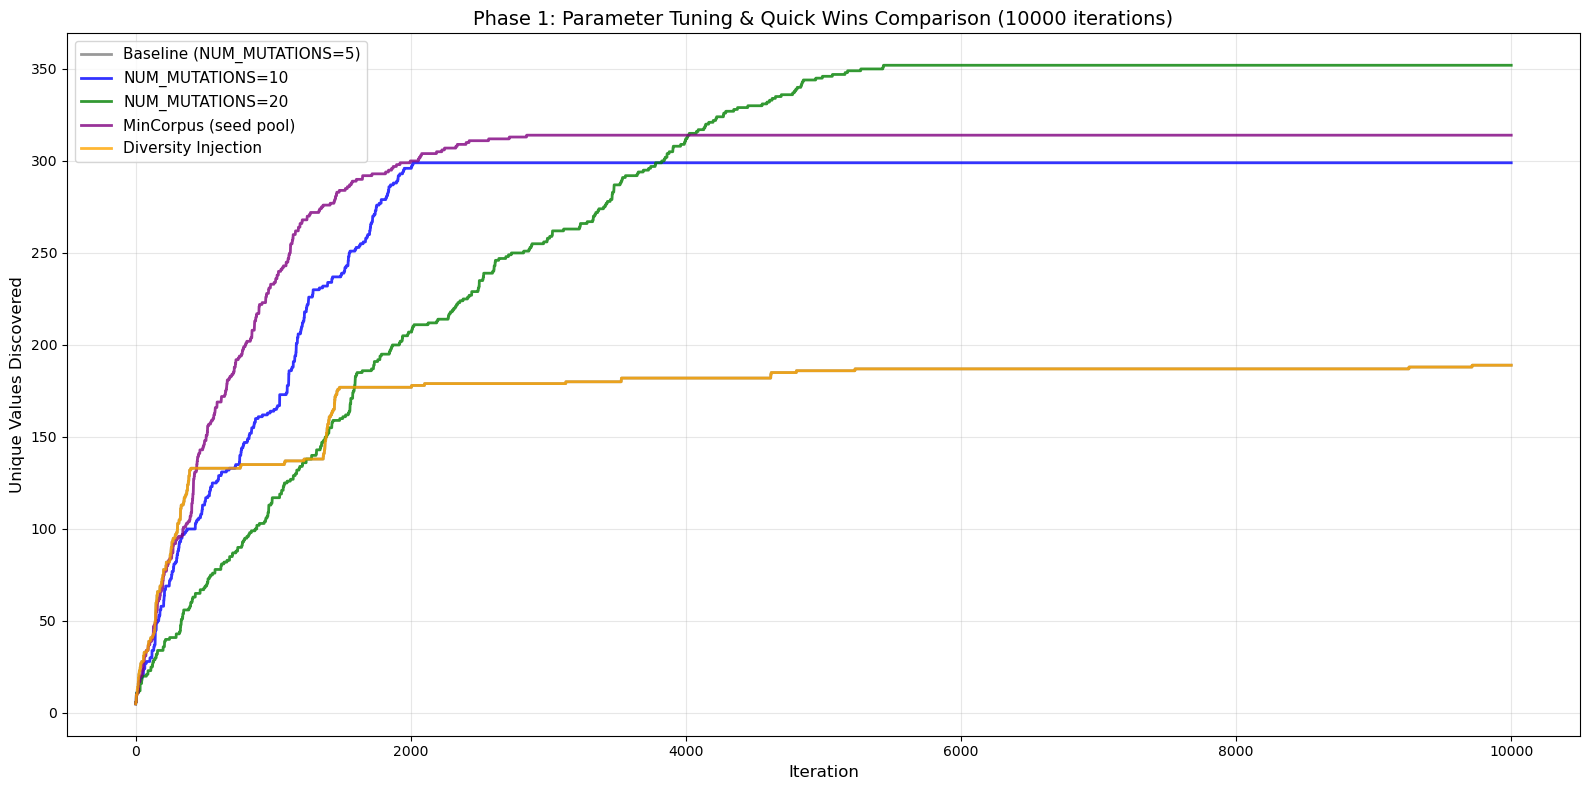


RESULTS SUMMARY
Strategy                        Final Coverage     vs Baseline
--------------------------------------------------------------------------------
Baseline (NUM_MUTATIONS=5)                 189       +0 ( +0.0%)
NUM_MUTATIONS=10                           299     +110 (+58.2%)
NUM_MUTATIONS=20                           352     +163 (+86.2%)
MinCorpus (seed pool)                      314     +125 (+66.1%)
Diversity Injection                        189       +0 ( +0.0%)

🏆 Best Strategy: NUM_MUTATIONS=20
   Final Coverage: 352
   Improvement over baseline: +163 (+86.2%)


In [512]:
# Comprehensive comparison of all Phase 1 strategies
print("=" * 80)
print("PHASE 1 FINAL COMPARISON")
print("=" * 80)

strategies = {
    'Baseline (NUM_MUTATIONS=5)': v2_coverage,
    'NUM_MUTATIONS=10': results[10]['coverage_data'],
    'NUM_MUTATIONS=20': results[20]['coverage_data'],
    'MinCorpus (seed pool)': min_corpus_coverage,
    'Diversity Injection': diversity_coverage,
}

# Plot all strategies
plt.figure(figsize=(16, 8))

colors_map = {
    'Baseline (NUM_MUTATIONS=5)': 'gray',
    'NUM_MUTATIONS=10': 'blue',
    'NUM_MUTATIONS=20': 'green',
    'MinCorpus (seed pool)': 'purple',
    'Diversity Injection': 'orange',
}

for name, coverage_data in strategies.items():
    plt.plot(coverage_data, label=name, color=colors_map[name], alpha=0.8, linewidth=2)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Unique Values Discovered', fontsize=12)
plt.title(f'Phase 1: Parameter Tuning & Quick Wins Comparison ({ITERS} iterations)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
print(f"{'Strategy':<30} {'Final Coverage':>15} {'vs Baseline':>15}")
print("-" * 80)

baseline = v2_coverage[-1]
for name, coverage_data in strategies.items():
    final = coverage_data[-1]
    diff = final - baseline
    pct = (diff / baseline * 100) if baseline > 0 else 0
    print(f"{name:<30} {final:>15d} {diff:>+8d} ({pct:>+5.1f}%)")

print("=" * 80)

# Find best strategy
best_name = max(strategies.keys(), key=lambda k: strategies[k][-1])
best_coverage = strategies[best_name][-1]
print(f"\n🏆 Best Strategy: {best_name}")
print(f"   Final Coverage: {best_coverage}")
print(f"   Improvement over baseline: +{best_coverage - baseline} (+{((best_coverage - baseline) / baseline * 100):.1f}%)")